# EWpredict

The goal of this project is to utilize machine learning algorithms to catagorize seismic records based on information produced by [Empirical Wavelet Method](https://github.com/Leviyu/EQTime). 

Being able to automatically predict the quality (accept or reject) of seismic record combined with Empriical Wavelet Making mathod would allows us to build seismic dataset in a fast, systematical and consistant manner. And being able to do so, would allow us to establish first step towards a new era for seismology.

## Work Flow

Below is the workflow that is implemented in this project:


### Feature Exploration
1. Explorationary Data Analysis with Virtualization

    a. check feature variable distribution

    b. check missing data

    c. check outlier
    
    d. convert certain numerical feature into categorial
    
    e. convert certain label features into categorial
    
    f. check correlation between different features
    
    
2. Feature engineering

    Analysis the correlation logic between feature and target variable and design new features by combine, compare or convert origonal features
    
### Model Training

3. Use training data to train different classification models

    and also cross-compare the performance of different models

4. Ensembling

    Construct layer models to improve the performance of final predict model
    
    
    
To make this project scaleable, we build pipeline that enable:
* Modularized feature transformations
* Automated grid search for parameter space
* Automated ensemble selection


In [115]:
# Import Necessary Library

import sys
import pandas as pd 
import matplotlib as plt
import numpy as np
import scipy as sp
import IPython
from IPython import display
import sklearn
import random
import time

import warnings
warnings.filterwarnings("ignore")
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

## Data

The data contains two parts, the first part is the raw seismic meta information produced my Empirical Wavelet Method.

The dataset we use here is constructed from 50 seismic events.

It contains all kind of features and also have pick information based on hardwired rules, which is not always reliable.

The second part is the binery quality label of each seismic meta record, which is manually labled and stored seperatedly as a file.

In [116]:
# Read in seismic meta info
data_file = "./data/eventinfo.EWPredict.50EQ.csv"
data = pd.read_csv(data_file,sep='\ ')
print("----> Read in seimic meta info for 50 events, dimension is {}".format(data.shape))




----> Read in seimic meta info for 50 events, dimension is (169446, 55)


In [117]:
# read in binery quality label
picked_flag = "./data/picked_flag.csv"
keep = pd.read_csv(picked_flag,sep=' ')
print("----> Read in quality label, dimension is {}".format(keep.shape))

----> Read in quality label, dimension is (260571, 1)


In [118]:
# Define new PICK flag from dataframe based on whether the quality label

y = data["EQ_NAME_STA_PHASE"].isin(keep.FLAG).astype(int)
data['DECISION'] = y

## Check pick rate amont all data
# 1 is accpeted
# 0 is rejected

pick_info = y.value_counts()
total_record = y.shape[0]
pick_rate = pick_info[1]/(pick_info[0]+pick_info[1])
print("Total number of records is: {:.0f}".format(y.shape[0]))
print("Totle number of records accepted is: {:.0f}".format(pick_info[1]))
print("#Accept Rate by Human check is: {:.2f}%".format(pick_info[1]/y.shape[0]*100))


Total number of records is: 169446
Totle number of records accepted is: 24505
#Accept Rate by Human check is: 14.46%


In [119]:
data['DECISION'].unique()

array([0, 1])

In [120]:
# check how many choices are different between code and human check

num_code = data[(data.QUALITY>=1)].shape[0]
num_human = data[(data.DECISION == 1)].shape[0]

print("Total record check by code is: {}/{}".format(num_code,total_record))
print("Total record check by human is: {}/{}".format(num_human,total_record))

# calculate match_rate

mask = ( data.QUALITY >=1 ) & (data.DECISION == 1) 
num_match = data[mask].shape[0]
match_percent = num_match 
print("#Match is: {}".format(match_percent))


Total record check by code is: 21022/169446
Total record check by human is: 24505/169446
#Match is: 14490


Confusion matrix, without normalization
[[138409   6532]
 [ 10015  14490]]
--------> Precision is 0.59 recall is 0.69 and F1 is 0.64
Normalized confusion matrix
[[0.95 0.05]
 [0.41 0.59]]
--------> Precision is 0.59 recall is 0.93 and F1 is 0.72


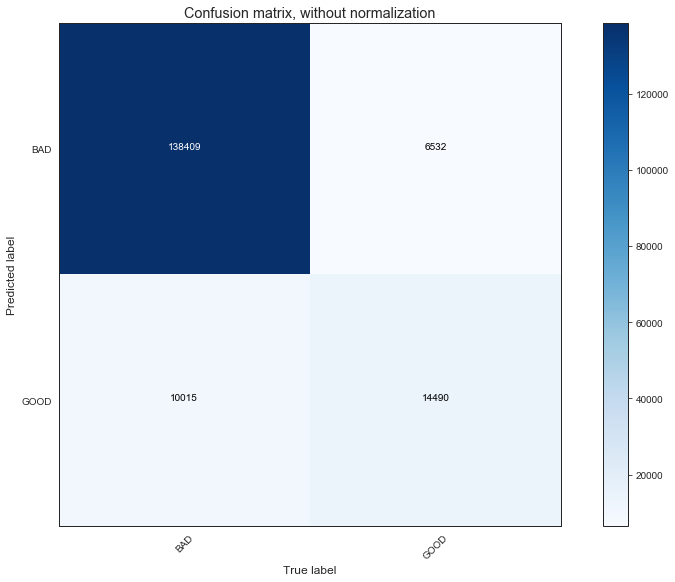

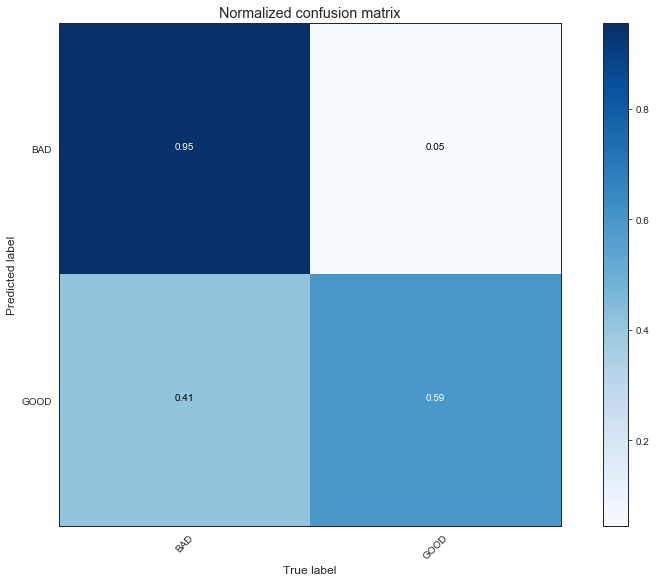

In [121]:
#Plot Accuracy Summary
#Credit: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    TP = cm[1][1]
    FN = cm[0][1]
    FP = cm[1][0]
    TN = cm[0][0]
#     print("TP is ",TP)
#     print("TN is ", TN)

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 = 2 * ( precision * recall ) / ( precision + recall)
    print("--------> Precision is {0:.2f} recall is {1:.2f} and F1 is {2:.2f}".format(precision,
                                                                         recall,
                                                                         F1))


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.xlabel('True label')
    plt.ylabel('Predicted label')

# make new columns show code decision
# data["CODE_DECISION"] = 0
data.loc[(data.QUALITY >=1),"CODE_DECISION"] = 1
data.loc[(data.QUALITY < 1),"CODE_DECISION"] = 0


# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(data.DECISION, data.CODE_DECISION)
np.set_printoptions(precision=2)

class_names = ['BAD', 'GOOD']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix')

In [122]:
mask = ( data.CODE_DECISION == data.DECISION )
match_percentage = 100*data[mask].shape[0]/data.shape[0]
match_percentage
print("Predicted accuracy by Empirical Wavelet Accuracy is: {}%".format(round(match_percentage,2)))
# data.CODE_DECISION.value_counts()

Predicted accuracy by Empirical Wavelet Accuracy is: 90.23%


In [123]:
# Calculate Precision and Recall of Empirical Wavelet Accuracy:
precision_pre = cnf_matrix[1][1] / (cnf_matrix[1][1]+cnf_matrix[1][0]) * 100
recall_pre = cnf_matrix[1][1]/ (cnf_matrix[1][1]+cnf_matrix[0][1] )*100
print("Precision: {:.2f}% Recall: {:.2f}%".format(round(precision_pre,2),
                                                 round(recall_pre,2)))

Precision: 59.13% Recall: 68.93%


## Step1: Define the Problem

Background: 
Though automated processing code I developed during my Ph.D. [EQTime](https://github.com/Leviyu/EQTime), I have collected a huge seismic dataset. The dataset consists of many scientific measurements as well as quality measurements. The nature of seismology is to identify confident signal from background noise. The dataset that I have gather contains records that can be used for seismic study and those that are too noise/or have other issues and thus should be rejected.

Each record should be classified into two catagories:
* Reject
* Accept

For the dataset that I have gathered, we have manually went through the dataset and make decision whether to accept or reject each record. Our goal is to see if we can use machine learning algorithm to learn our decision choices.

This is a classic binary classification problem in machine learning.

## Data Exploration

In [124]:
data.head()

,STA,NET,DIST,AZ,BAZ,STA_LAT,STA_LON,EQ_LAT,EQ_LON,EQ_DEP,...,BAK2T,BAK3T,SNR_TROUGH,SNR_PEAK,SNR_SMALL,TRAFFIC_IN_NOISE,ONE_PERIOD,EQ_NAME_STA_PHASE,DECISION,CODE_DECISION
0,INCN,IU,35.589,0.669,180.840,37.478,126.624,1.718,126.135,107.1,...,0.78,0.26,0.0,0.0,0,0,24.0,199602280944_INCN_ScSScS_1,0,1.0
1,INCN_PPP,IU,35.589,0.669,180.840,37.478,126.624,1.718,126.135,107.1,...,0.65,0.58,0.0,0.0,0,0,24.0,199602280944_INCN_PPP_ScSScS_-1,0,0.0
2,BGCA,GT,107.469,275.933,86.580,5.176,18.424,1.718,126.135,107.1,...,0.55,-0.00,0.0,0.0,0,1,33.0,199602280944_BGCA_ScSScS_-1,0,1.0
3,EVO,G,121.840,318.513,57.594,38.532,-8.013,1.718,126.135,107.1,...,0.14,0.06,0.0,0.0,0,0,26.8,199602280944_EVO_ScSScS_-1,0,1.0
4,KOG,G,173.029,350.660,9.374,5.207,-52.732,1.718,126.135,107.1,...,0.29,0.39,0.0,0.0,0,0,28.2,199602280944_KOG_ScSScS_1,0,0.0


In [125]:
data.isnull().sum()
# data.shape

STA                    0
NET                  168
DIST                   0
AZ                     0
BAZ                    0
STA_LAT                0
STA_LON                0
EQ_LAT                 0
EQ_LON                 0
EQ_DEP                 0
EQ_MAG                 0
EQ_NAME                0
POLARFLAG              0
QUALITY                0
PREM                   0
AMP                    0
CCC1                   0
SNRAVE                22
DT                     0
PHASE                  0
STRETCHC               0
STRETCHF               0
MISFITSIG              0
COMP                   0
TAG1                   0
TAG2                   0
TAG3                   0
TAG4                   0
TAG5                   0
WEIGHT                 5
TAG6                   0
TAG7                   0
ONSET                  0
ENDSET                 0
TSTARF                 0
TSTARC                 0
CCC2                   0
MISFITPRE              0
MISFITBAK              0
GRECORD                0


In [126]:
# Check for null value and clean
data.NET.fillna("NNN",inplace=True)
data = data.dropna()
data.isnull().sum()

STA                  0
NET                  0
DIST                 0
AZ                   0
BAZ                  0
STA_LAT              0
STA_LON              0
EQ_LAT               0
EQ_LON               0
EQ_DEP               0
EQ_MAG               0
EQ_NAME              0
POLARFLAG            0
QUALITY              0
PREM                 0
AMP                  0
CCC1                 0
SNRAVE               0
DT                   0
PHASE                0
STRETCHC             0
STRETCHF             0
MISFITSIG            0
COMP                 0
TAG1                 0
TAG2                 0
TAG3                 0
TAG4                 0
TAG5                 0
WEIGHT               0
TAG6                 0
TAG7                 0
ONSET                0
ENDSET               0
TSTARF               0
TSTARC               0
CCC2                 0
MISFITPRE            0
MISFITBAK            0
GRECORD              0
GSEW                 0
GMISFIT              0
POLARITY             0
POLAR_RIGHT

In [127]:
print("size of data is {}".format(data.shape))

size of data is (169282, 57)


In [128]:
# check the existing column
# list(data.columns)
# data['SNR_TROUGH'].unique()

In [129]:
# drop columns that is obviously not correlated with the quality of the record
drop_list = [
"STA",
'EQ_LAT',
'EQ_LON',
'PREM',
'AMP',
'TAG1',
'TAG2',
'TAG3',
'TAG4',
'TAG5',
'TAG6',
'TAG7',
'ONSET',
'ENDSET',
'GSEW',
'PRE3T',
'BAK3T',
"EQ_NAME_STA_PHASE",
"AZ",
"BAZ",
"STA_LAT",
"STA_LON",
"SNR_SMALL",
"SNR_PEAK",
"SNR_TROUGH",
'COMP'
]
data = data.drop(drop_list,axis=1)

In [130]:
list(data.columns)

['NET',
 'DIST',
 'EQ_DEP',
 'EQ_MAG',
 'EQ_NAME',
 'POLARFLAG',
 'QUALITY',
 'CCC1',
 'SNRAVE',
 'DT',
 'PHASE',
 'STRETCHC',
 'STRETCHF',
 'MISFITSIG',
 'WEIGHT',
 'TSTARF',
 'TSTARC',
 'CCC2',
 'MISFITPRE',
 'MISFITBAK',
 'GRECORD',
 'GMISFIT',
 'POLARITY',
 'POLAR_RIGHT',
 'TRAFFIC',
 'PRE2T',
 'BAK2T',
 'TRAFFIC_IN_NOISE',
 'ONE_PERIOD',
 'DECISION',
 'CODE_DECISION']

In [131]:
# new data shape 
print("New shape is: {}".format(data.shape))

New shape is: (169282, 31)


In [132]:
# Feature Engineering
data.info()
# data.sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169282 entries, 0 to 169445
Data columns (total 31 columns):
NET                 169282 non-null object
DIST                169282 non-null float64
EQ_DEP              169282 non-null float64
EQ_MAG              169282 non-null float64
EQ_NAME             169282 non-null int64
POLARFLAG           169282 non-null int64
QUALITY             169282 non-null int64
CCC1                169282 non-null float64
SNRAVE              169282 non-null float64
DT                  169282 non-null float64
PHASE               169282 non-null object
STRETCHC            169282 non-null float64
STRETCHF            169282 non-null float64
MISFITSIG           169282 non-null float64
WEIGHT              169282 non-null float64
TSTARF              169282 non-null float64
TSTARC              169282 non-null float64
CCC2                169282 non-null float64
MISFITPRE           169282 non-null float64
MISFITBAK           169282 non-null float64
GRECORD          

### Clean outlier

In [133]:
# Clean up outlier
mask =  ( data.BAK2T > 5)
data.loc[mask,"BAK2T"] = 5

mask = (data.MISFITBAK > 5)
data.loc[mask,"MISFITBAK"] = 5

mask = (data.MISFITPRE > 2)
data.loc[mask,"MISFITPRE"] = 2

mask = (data.MISFITSIG > 5)
data.loc[mask,"MISFITSIG"] = 5

mask = (data.PRE2T > 5)
data.loc[mask,"PRE2T"] = 5

mask = (data.SNRAVE > 50)
data.loc[mask,"SNRAVE"] = 50

# mask = (data.SNR_PEAK > 50)
# data.loc[mask,"SNR_PEAK"] = 50
# mask = (data.SNR_PEAK < 0)
# data.loc[mask,"SNR_PEAK"] = 0

# mask = (data.SNR_TROUGH > 50)
# data.loc[mask,"SNR_TROUGH"] = 50
# mask = (data.SNR_TROUGH < 0)
# data.loc[mask,"SNR_TROUGH"] = 0

# Check histograms of all columns
# data.hist(layout=(30,1),figsize=(5,36))
# plt.subplots_adjust(hspace=1.5)
# plt.show()


In [134]:
# Backup original data
data_raw = data.copy()

In [135]:
# Classify different features into numerical and categorial features
numerical_feature = [
'DIST', 'CCC1', 'SNRAVE', 'DT',
'STRETCHC', 'STRETCHF', 'MISFITSIG', 'WEIGHT', 'TSTARF',
'TSTARC', 'CCC2', 'MISFITPRE', 'MISFITBAK', 'GRECORD', 'GMISFIT',
'POLARITY', 'PRE2T', 'BAK2T',
'ONE_PERIOD',
'EQ_DEP',
    'EQ_MAG',
    

                    
                    ]
categorial_feature = [
'NET', 
'POLARFLAG', 
'QUALITY',

'POLAR_RIGHT',
'TRAFFIC_IN_NOISE',

    'TRAFFIC'
    ]
dummy_feature = [
    'PHASE',
]


print("total feature num is {0} numerical feature num is {1} categorial feature num is {2}".format(
data.shape[1],len(numerical_feature),len(categorial_feature)))

feat_resi = [x for x in data.columns if x not in numerical_feature if x not in categorial_feature
            if x not in dummy_feature]
print(feat_resi)


total feature num is 31 numerical feature num is 21 categorial feature num is 6
['EQ_NAME', 'DECISION', 'CODE_DECISION']


In [136]:
# For categorial features, we directly label encode them

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore',categorical_features=[0])
label = LabelEncoder()    

# for categorial feature, we use label endocing
for feature in categorial_feature:
    print("--> Work on ", feature)
    data[feature] = label.fit_transform(data[feature])
    
# For dummy variable we use onehotencoding
new_dummy = []
for feature in dummy_feature:
    print("--> work on dummy feature", feature)
    ff = pd.get_dummies(data[feature])
    for f in ff.columns:
        new_dummy.append(f)
    data = pd.concat([data,ff],axis=1)
    data.drop(feature,inplace=True,axis=1)
    
print("new dummy features are ", new_dummy)

--> Work on  NET
--> Work on  POLARFLAG
--> Work on  QUALITY
--> Work on  POLAR_RIGHT
--> Work on  TRAFFIC_IN_NOISE
--> Work on  TRAFFIC
--> work on dummy feature PHASE
new dummy features are  ['S', 'SS', 'SSS', 'ScS', 'ScSScS', 'Sdiff']


## Data Exploration


In [137]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169282 entries, 0 to 169445
Data columns (total 36 columns):
NET                 169282 non-null int64
DIST                169282 non-null float64
EQ_DEP              169282 non-null float64
EQ_MAG              169282 non-null float64
EQ_NAME             169282 non-null int64
POLARFLAG           169282 non-null int64
QUALITY             169282 non-null int64
CCC1                169282 non-null float64
SNRAVE              169282 non-null float64
DT                  169282 non-null float64
STRETCHC            169282 non-null float64
STRETCHF            169282 non-null float64
MISFITSIG           169282 non-null float64
WEIGHT              169282 non-null float64
TSTARF              169282 non-null float64
TSTARC              169282 non-null float64
CCC2                169282 non-null float64
MISFITPRE           169282 non-null float64
MISFITBAK           169282 non-null float64
GRECORD             169282 non-null float64
GMISFIT          

--> work on  NET
--> work on  POLARFLAG
--> work on  QUALITY
--> work on  POLAR_RIGHT
--> work on  TRAFFIC_IN_NOISE
--> work on  TRAFFIC


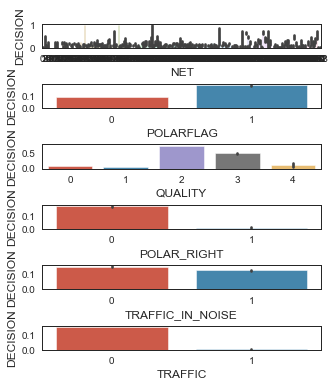

In [139]:
# Virtualize the correlation of each feature

# my_feature = categorial_feature + numerical_feature + dummy_feature
my_feature = categorial_feature
fignum = len(my_feature)

fig, axes = plt.subplots(fignum,1,figsize=(5,fignum))
plt.subplots_adjust(hspace=1.5)

for index,feature in enumerate(my_feature):
    print("--> work on ",feature)
    sns.barplot(x=feature,y='DECISION',data=data,ax=axes[index])

plt.show()

--> work on  S
--> work on  SS
--> work on  SSS
--> work on  ScS
--> work on  ScSScS
--> work on  Sdiff


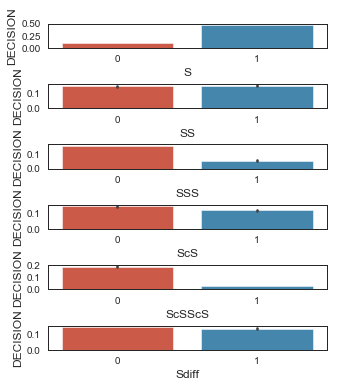

In [138]:
# Virtualize the correlation of each feature

# my_feature = categorial_feature + numerical_feature + dummy_feature
my_feature = new_dummy
fignum = len(my_feature)

fig, axes = plt.subplots(fignum,1,figsize=(5,fignum))
plt.subplots_adjust(hspace=1.5)

for index,feature in enumerate(my_feature):
    print("--> work on ",feature)
    sns.barplot(x=feature,y='DECISION',data=data,ax=axes[index])

plt.show()

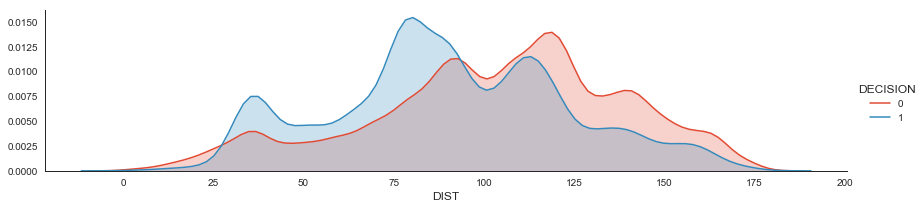

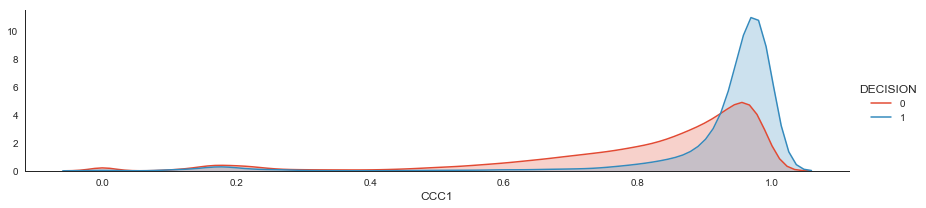

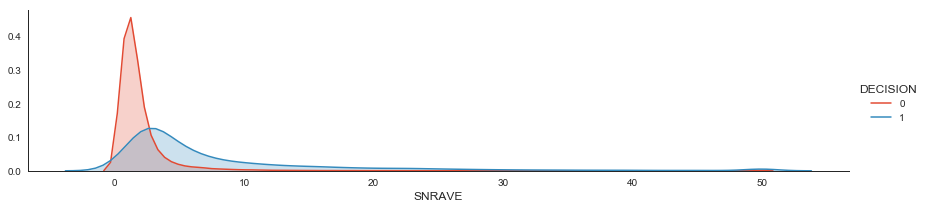

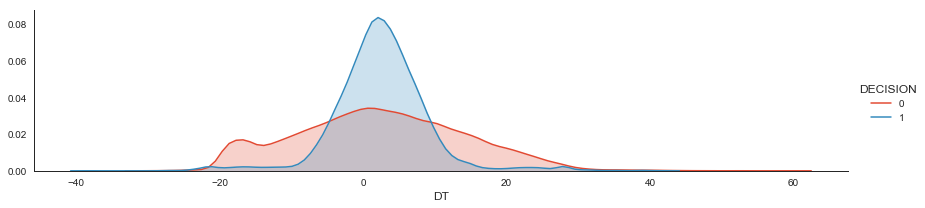

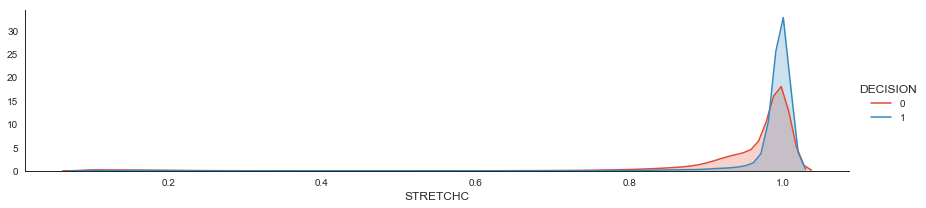

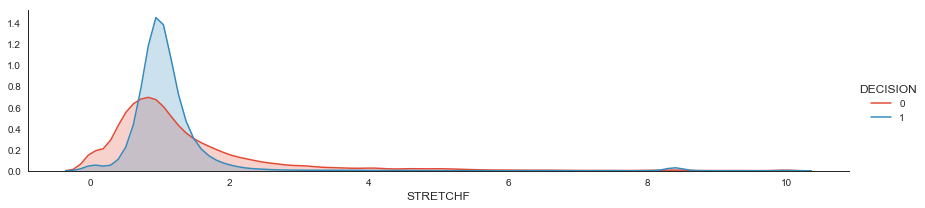

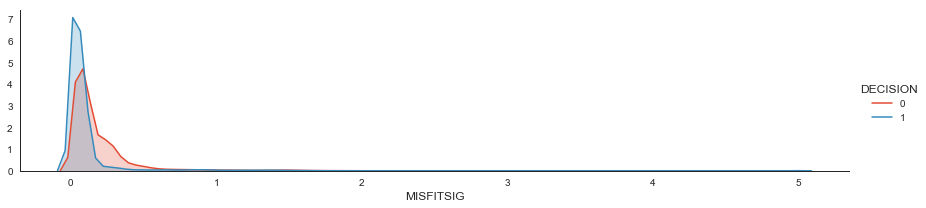

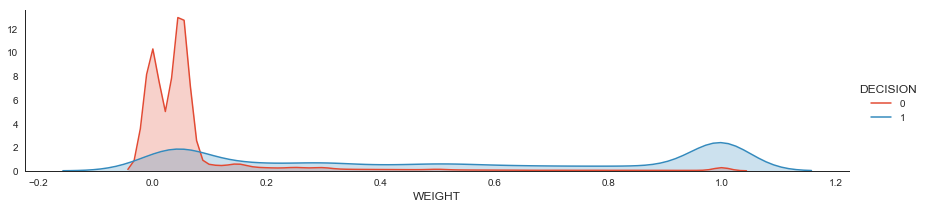

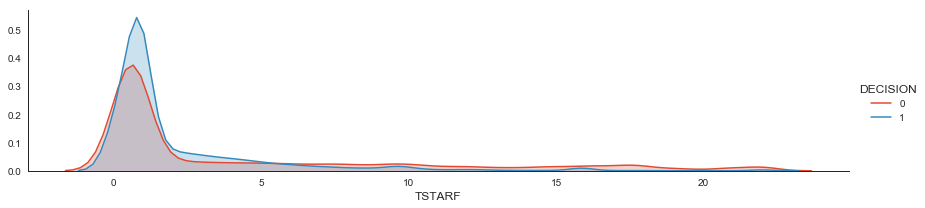

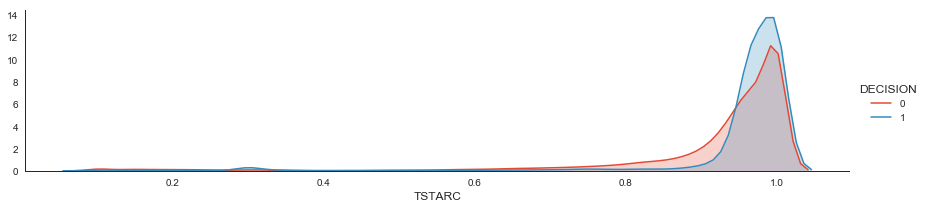

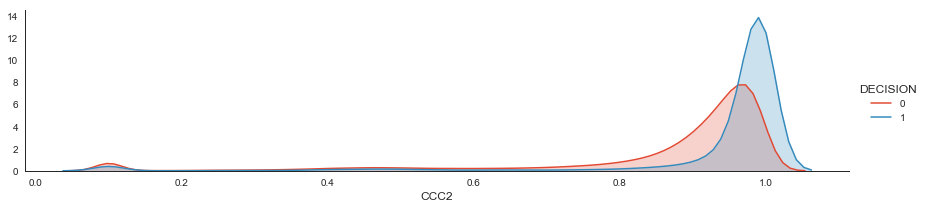

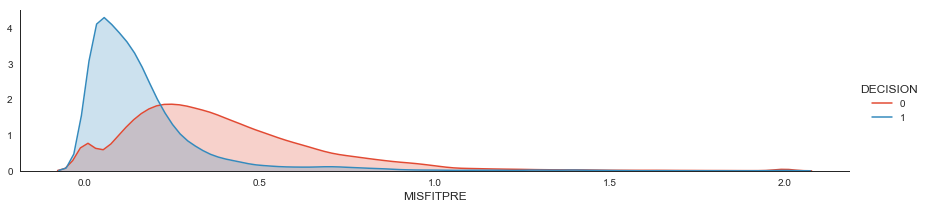

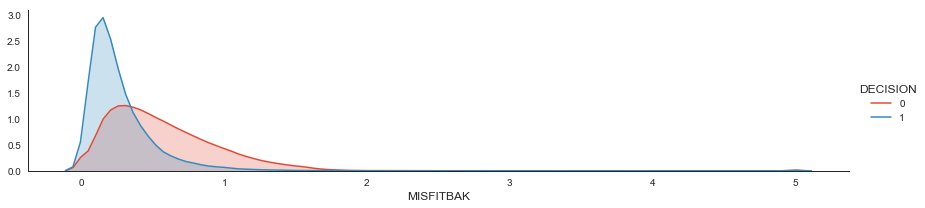

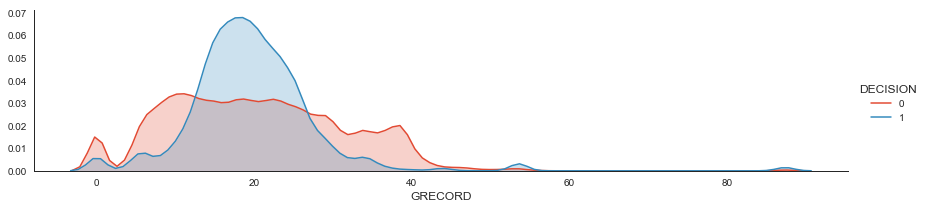

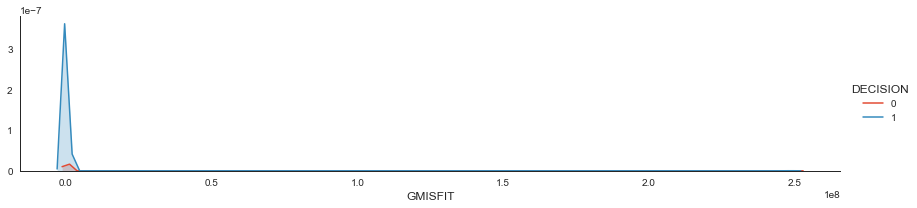

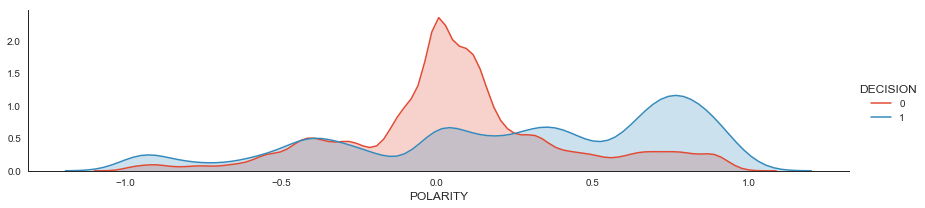

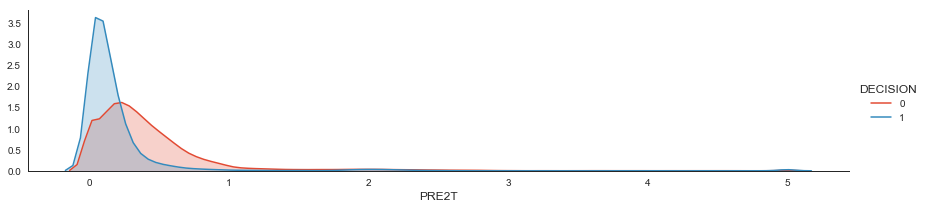

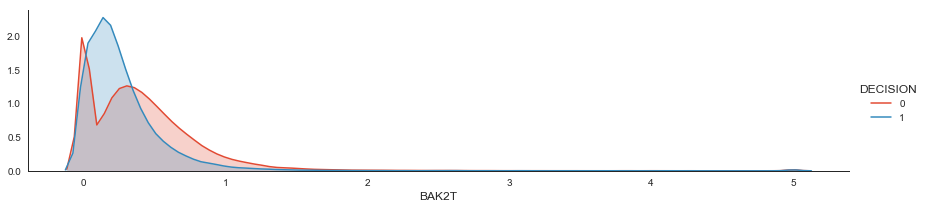

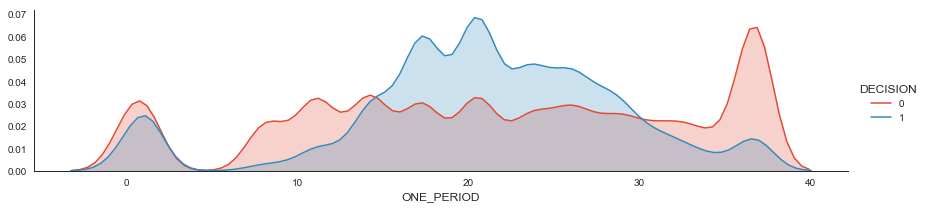

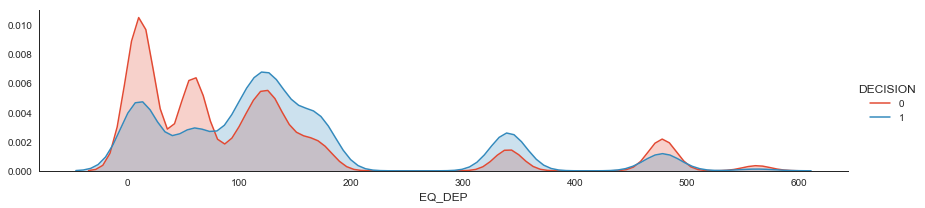

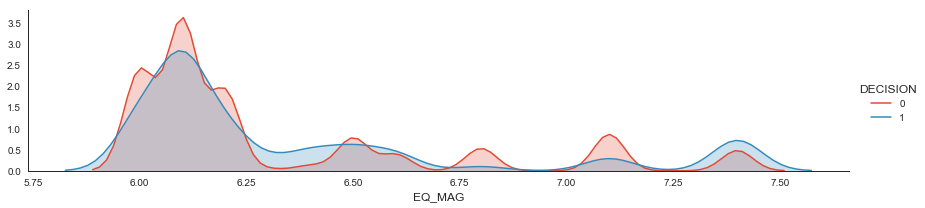

In [140]:
# For numerial features, we use ked plot to plot the correlation

for feature in numerical_feature:
    print('----> Work on feature ', feature)
    a = sns.FacetGrid(data,hue="DECISION",aspect=4)
    a.map(sns.kdeplot,feature,shade=True)
    # a.set(xlim=(0,10))
    a.add_legend()


In [154]:
# For distance, we divide by each degree
feat = 'DIST'
bins = np.linspace(0,180,181)
data[feat] = pd.cut(data[feat],bins,labels=False)


In [155]:
feat = 'CCC1'
bins = np.linspace(0,1,50)
data[feat] = pd.cut(data[feat],bins,labels=False)

feat = 'SNRAVE'
bins = 30
data[feat] = pd.cut(data[feat],bins,labels=False)




0          35
1          35
2         107
3         121
4         173
5         173
6          23
7          23
8          27
9          29
10         32
11         34
12         34
13         35
14         35
15         35
16         35
17         35
18         35
19         36
20         36
21         42
22         42
23         45
24         45
25         45
26         45
27         49
28         53
29         53
         ... 
169416     96
169417     96
169418     96
169419     96
169420     97
169421     97
169422     97
169423     97
169424     97
169425     97
169426     97
169427     97
169428     97
169429     97
169430     97
169431     97
169432     97
169433     98
169434     98
169435     98
169436     98
169437     98
169438     99
169439     99
169440    100
169441    100
169442    100
169443    100
169444    101
169445    101
Name: DIST, Length: 169282, dtype: int64

[(-0.001, 24.75], (-0.001, 24.75], (-0.001, 24.75], (-0.001, 24.75], (-0.001, 24.75], ..., (74.25, 99.0], (74.25, 99.0], (74.25, 99.0], (74.25, 99.0], (74.25, 99.0]]
Length: 100
Categories (4, interval[float64]): [(-0.001, 24.75] < (24.75, 49.5] < (49.5, 74.25] < (74.25, 99.0]]

In [36]:
# # get Pearson Correlation of Features
# def correlation_heatmap(df):
#     _ , ax = plt.subplots(figsize =(14, 12))
#     colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
#     _ = sns.heatmap(
#         df.corr(), 
#         cmap = colormap,
#         square=True, 
#         cbar_kws={'shrink':.9 }, 
#         ax=ax,
#         annot=True, 
#         linewidths=0.1,vmax=1.0, linecolor='white',
#         annot_kws={'fontsize':12 }
#     )
# plt.title("Pearson Correlation of Features",y=1.05,size=15)
# correlation_heatmap(data)

In [37]:
# my_feature

In [38]:
# my_feature.drop(columns=['EQ_NAME'])
my_feature.columns
# my_feature.EQ_NAME

Index(['DIST_new', 'CCC1_new', 'SNRAVE_new', 'DT_new', 'STRETCHC_new',
       'STRETCHF_new', 'MISFITSIG_new', 'WEIGHT_new', 'TSTARF_new',
       'TSTARC_new', 'CCC2_new', 'MISFITPRE_new', 'MISFITBAK_new',
       'GRECORD_new', 'GMISFIT_new', 'POLARITY_new', 'PRE2T_new', 'BAK2T_new',
       'ONE_PERIOD_new', 'NET_new', 'POLARFLAG_new', 'QUALITY_new',
       'PHASE_new', 'POLAR_RIGHT_new', 'TRAFFIC_IN_NOISE_new'],
      dtype='object')

In [39]:
# Divide data into train/validate/test 
# Here we specify one event to be test dataset
mask = data.EQ_NAME.isin(["201503102055"])

# reserve one event for test set
data_test = data[mask]
data_train_validate = data[~mask]
x_bench = data_test[my_feature_list]
y_bench = data_test['DECISION']


# x_train/y_train are training set
# x_test/y_test are validation set
my_feature = data_train_validate[my_feature_list]
my_target = data_train_validate['DECISION']

x_train, x_test, y_train, y_test = model_selection.train_test_split(
my_feature,my_target,test_size=0.20,random_state=31)


In [40]:
data_test.columns

Index(['NET', 'DIST', 'EQ_NAME', 'POLARFLAG', 'QUALITY', 'CCC1', 'SNRAVE',
       'DT', 'PHASE', 'STRETCHC', 'STRETCHF', 'MISFITSIG', 'WEIGHT', 'TSTARF',
       'TSTARC', 'CCC2', 'MISFITPRE', 'MISFITBAK', 'GRECORD', 'GMISFIT',
       'POLARITY', 'POLAR_RIGHT', 'PRE2T', 'BAK2T', 'TRAFFIC_IN_NOISE',
       'ONE_PERIOD', 'DECISION', 'CODE_DECISION', 'DIST_new', 'CCC1_new',
       'SNRAVE_new', 'DT_new', 'STRETCHC_new', 'STRETCHF_new', 'MISFITSIG_new',
       'WEIGHT_new', 'TSTARF_new', 'TSTARC_new', 'CCC2_new', 'MISFITPRE_new',
       'MISFITBAK_new', 'GRECORD_new', 'GMISFIT_new', 'POLARITY_new',
       'PRE2T_new', 'BAK2T_new', 'ONE_PERIOD_new', 'NET_new', 'POLARFLAG_new',
       'QUALITY_new', 'PHASE_new', 'POLAR_RIGHT_new', 'TRAFFIC_IN_NOISE_new'],
      dtype='object')

In [41]:
# make another color show Empirical Wavelet decision
data_test["EW_DECISION"] = data_test.QUALITY_new
def reduce_quality(value):
    if value>=1:
        return 1
    else:
        return 0
data_test.EW_DECISION = data_test.EW_DECISION.apply(reduce_quality)

y_EW = data_test.EW_DECISION

In [42]:
print(x_train.shape)
print(x_test.shape)

(130140, 25)
(32535, 25)


In [43]:
y_test.shape

(32535,)

In [44]:
my_target.value_counts()

0    139212
1     23463
Name: DECISION, dtype: int64

In [51]:
from sklearn.tree import DecisionTreeClassifier as dtree
algs = [LogisticRegression(),dtree(),RandomForestClassifier(),
        GaussianNB()]
# KNeighborsClassifier(),
MLA_Columns = ["MLA Name","Train Accuracy","CV Accuracy","Time"]
MLA_compare = pd.DataFrame(columns=MLA_Columns)

cv_split = model_selection.ShuffleSplit(n_splits=5,test_size=0.3,
                                       train_size=0.7,random_state=43)

row_index = 0
for alg in algs:
    print(alg)
    cv_result = model_selection.cross_validate(alg,x_train,y_train,cv=cv_split)
    MLA_compare.loc[row_index,"MLA Name"] = alg.__class__.__name__
    MLA_compare.loc[row_index,"Train Accuracy"] = cv_result["train_score"].mean()
    MLA_compare.loc[row_index,"CV Accuracy"] = cv_result["test_score"].mean()
    MLA_compare.loc[row_index,"Time"] = cv_result["fit_time"].mean()
    row_index+=1
    

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbo

In [52]:
MLA_compare.sort_values(by=["CV Accuracy"],ascending=False,inplace=True)
MLA_compare

,MLA Name,Train Accuracy,CV Accuracy,Time
2,RandomForestClassifier,0.994182,0.937129,1.48364
0,LogisticRegression,0.91629,0.915245,1.83302
1,DecisionTreeClassifier,0.99957,0.910855,0.856841
3,GaussianNB,0.874188,0.874381,0.105373


In [ ]:
# # Use decision tree to benchmark the dataset to see if decision tree would 
# # be a good model
# my_data = pd.concat([my_feature,my_target],axis=1)
# my_data.columns
# tree = my_data.groupby(["SNRAVE_Code","CCC1_Code","CCC2_Code","MISFITSIG_Code"])["DECISION"].mean()
# tree

In [53]:
# # use random forest
rf = RandomForestClassifier()
rf_result = model_selection.cross_validate(rf,my_feature,my_target,cv=5)
# rf.fit(my_feature,my_target)
# rf.score(my_feature,my_target)

In [54]:
# Cross validate random forest method
rf = RandomForestClassifier()
scores = model_selection.cross_val_score(rf, my_feature, my_target, cv=cv_split)
print("Cross Validate Random Forest result: {}".format(scores))
print("Mean is: {}".format(scores.mean()))

Cross Validate Random Forest result: [0.94 0.94 0.94 0.94 0.94]
Mean is: 0.9379915169149438


In [55]:
# We use dtree and try feature selection
print("BEFORE DT FEATURE SELECTION Train score mean: {:.4f}".format(rf_result["train_score"].mean()))
print("BEFORE DT FEATURE SELECTION Test score mean: {:.4f}".format(rf_result["test_score"].mean()))
print("BEFORE DT FEATURE SELECTION 3std: {:.4f}".format(rf_result["test_score"].std()*3))

rf_rfe = feature_selection.RFECV(rf,step=0.3,scoring='accuracy',cv=cv_split)
rf_rfe.fit(my_feature,my_target)
print(my_feature.columns)
x_rfe = my_feature.columns.values[rf_rfe.get_support()]
x_rfe

BEFORE DT FEATURE SELECTION Train score mean: 0.9946
BEFORE DT FEATURE SELECTION Test score mean: 0.9008
BEFORE DT FEATURE SELECTION 3std: 0.0298
Index(['DIST_new', 'CCC1_new', 'SNRAVE_new', 'DT_new', 'STRETCHC_new',
       'STRETCHF_new', 'MISFITSIG_new', 'WEIGHT_new', 'TSTARF_new',
       'TSTARC_new', 'CCC2_new', 'MISFITPRE_new', 'MISFITBAK_new',
       'GRECORD_new', 'GMISFIT_new', 'POLARITY_new', 'PRE2T_new', 'BAK2T_new',
       'ONE_PERIOD_new', 'NET_new', 'POLARFLAG_new', 'QUALITY_new',
       'PHASE_new', 'POLAR_RIGHT_new', 'TRAFFIC_IN_NOISE_new'],
      dtype='object')


array(['DIST_new', 'CCC1_new', 'SNRAVE_new', 'DT_new', 'STRETCHC_new',
       'STRETCHF_new', 'MISFITSIG_new', 'WEIGHT_new', 'TSTARF_new',
       'TSTARC_new', 'CCC2_new', 'MISFITPRE_new', 'MISFITBAK_new',
       'GRECORD_new', 'GMISFIT_new', 'POLARITY_new', 'PRE2T_new',
       'BAK2T_new', 'ONE_PERIOD_new', 'NET_new', 'POLARFLAG_new',
       'QUALITY_new', 'PHASE_new', 'POLAR_RIGHT_new',
       'TRAFFIC_IN_NOISE_new'], dtype=object)

In [56]:
# use selected feature to train again
new_feature = my_feature[x_rfe]
rf = RandomForestClassifier()
rf2_result = model_selection.cross_validate(rf,new_feature,my_target,cv=cv_split)
print("AFTER DT FEATURE SELECTION Train score mean: {:.4f}".format(rf2_result["train_score"].mean()))
print("AFTER DT FEATURE SELECTION Test score mean: {:.4f}".format(rf2_result["test_score"].mean()))
print("AFTER DT FEATURE SELECTION 3std: {:.4f}".format(rf2_result["test_score"].std()*3))

AFTER DT FEATURE SELECTION Train score mean: 0.9943
AFTER DT FEATURE SELECTION Test score mean: 0.9387
AFTER DT FEATURE SELECTION 3std: 0.0019


In [80]:
# use randomforest to predict for test data
clf = RandomForestClassifier(random_state=0)
# clf = DecisionTreeClassifier(random_state=0)
model = clf.fit(my_feature,my_target)
y_predict = clf.predict(x_bench)


In [81]:
# get the difference between y_test and y_predict
mask = ( y_bench != y_predict)
num_dif = y_predict[mask].shape[0]
num_test_all = y_predict.shape[0]
predict_rate = (1- num_dif / num_test_all ) *100
print("Use Randomforest to predict test dataset, score is: {:.2f}%".format(predict_rate))


Use Randomforest to predict test dataset, score is: 93.61%


Confusion matrix, without normalization
[[3124 2442]
 [ 560  481]]
Normalized confusion matrix
[[0.56 0.44]
 [0.54 0.46]]
Precision: 46.21% Recall: 16.46% F: 24.27


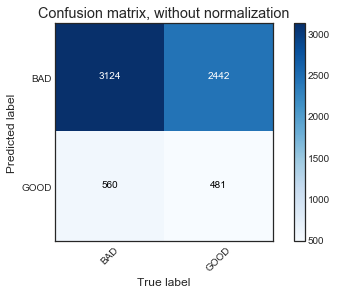

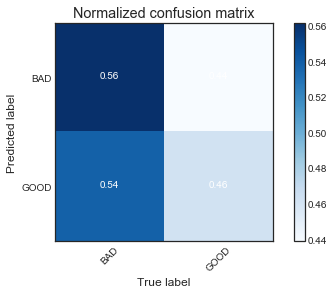

In [82]:
# #Plot Accuracy Summary
#Credit: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.xlabel('True label')
    plt.ylabel('Predicted label')




# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_bench,y_EW)
np.set_printoptions(precision=2)

class_names = ['BAD', 'GOOD']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix')

# Calculate Precision and Recall of Empirical Wavelet Accuracy:
precision_af = cnf_matrix[1][1] / (cnf_matrix[1][1]+cnf_matrix[1][0]) * 100
recall_af = cnf_matrix[1][1]/ (cnf_matrix[1][1]+cnf_matrix[0][1] )*100

F_score = 2* (precision_af*recall_af)/(precision_af+recall_af)
print("Precision: {:.2f}% Recall: {:.2f}% F: {:.2f}".format(round(precision_af,2),
                                                 round(recall_af,2),
     round(F_score,2)))



Confusion matrix, without normalization
[[5458  108]
 [ 314  727]]
Normalized confusion matrix
[[0.98 0.02]
 [0.3  0.7 ]]
Precision: 69.84% Recall: 87.07% F: 77.51


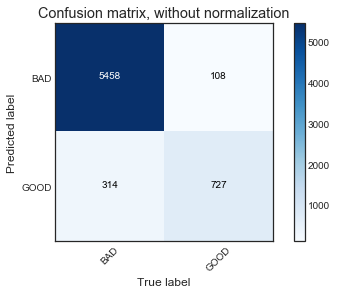

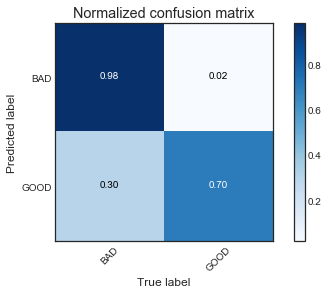

In [83]:
# #Plot Accuracy Summary
#Credit: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.xlabel('True label')
    plt.ylabel('Predicted label')




# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_bench,y_predict)
np.set_printoptions(precision=2)

class_names = ['BAD', 'GOOD']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix')

# Calculate Precision and Recall of Empirical Wavelet Accuracy:
precision_af = cnf_matrix[1][1] / (cnf_matrix[1][1]+cnf_matrix[1][0]) * 100
recall_af = cnf_matrix[1][1]/ (cnf_matrix[1][1]+cnf_matrix[0][1] )*100

F_score = 2* (precision_af*recall_af)/(precision_af+recall_af)
print("Precision: {:.2f}% Recall: {:.2f}% F: {:.2f}".format(round(precision_af,2),
                                                 round(recall_af,2),
     round(F_score,2)))


In [84]:
# virtual decision tree
# Load libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets
from IPython.display import Image  
from sklearn import tree
import pydotplus
import graphviz

In [86]:
# mega_feature = my_feature_list + ["DECISION"]
# clf = RandomForestClassifier(random_state=0)
clf = DecisionTreeClassifier(random_state=0)
model = clf.fit(my_feature,my_target)
dot_data = tree.export_graphviz(clf,out_file=None,
                               feature_names = my_feature_list,
                               class_names=["0","1"])

In [88]:
# graph = pydotplus.graph_from_dot_data(dot_data)
# # Image(graph.create_png())
# graph.write_png("Dtree.png")
# clf.fit_transform()

In [90]:
# graph = graphviz.Source(dot_data)
# graph

In [ ]:
plt.show()